# Retina Damage Detection from OCT Images

Author: Nidhish Kumar

Last Updated: 23-05-2023

## Metadata of the Dataset

The dataset contains approximately 84,000 OCT training images, 32 validation images and 968 test images distributed among 4 classes.

Each image belongs to one these classes:

- CNV
- DME
- DRUSEN
- NORMAL

<small style="color: red">NOTE: In this notebook, we are using the test dataset as validation dataset because the size of the original validation dataset is too small.</small>

## Downloading the Dataset

We download the [retinal OCT images dataset](https://www.kaggle.com/datasets/paultimothymooney/kermany2018) for training the model.

In [ ]:
# downloading the dataset using kaggle API

!kaggle datasets download -d paultimothymooney/kermany2018

## Importing necessary modules

We import the following modules to read the data, visualize the data and create a model:

- **Matplotlib** to read and visualize the data
- **scikit-image** to read and visualize the data
- **TensorFlow** to create model

In [34]:
import os

import matplotlib.pyplot as plt
from matplotlib.image import imread
from skimage import io


import tensorflow as tf

In [35]:
# checking GPU

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [76]:
! nvidia-smi

Tue May 23 01:18:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.78       Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   43C    P8     3W /  N/A |   2908MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Exploring the Dataset

In [37]:
parent_dir = "./kermany2018/OCT2017"
train_dir = os.path.join(parent_dir, "train")
val_dir = os.path.join(parent_dir, "test") # not using the val folder because it has too less samples for validation
test_dir = os.path.join(parent_dir, "val")

HEIGHT = 128
WIDTH = 128
BATCH_SIZE = 32
EPOCHS = 12

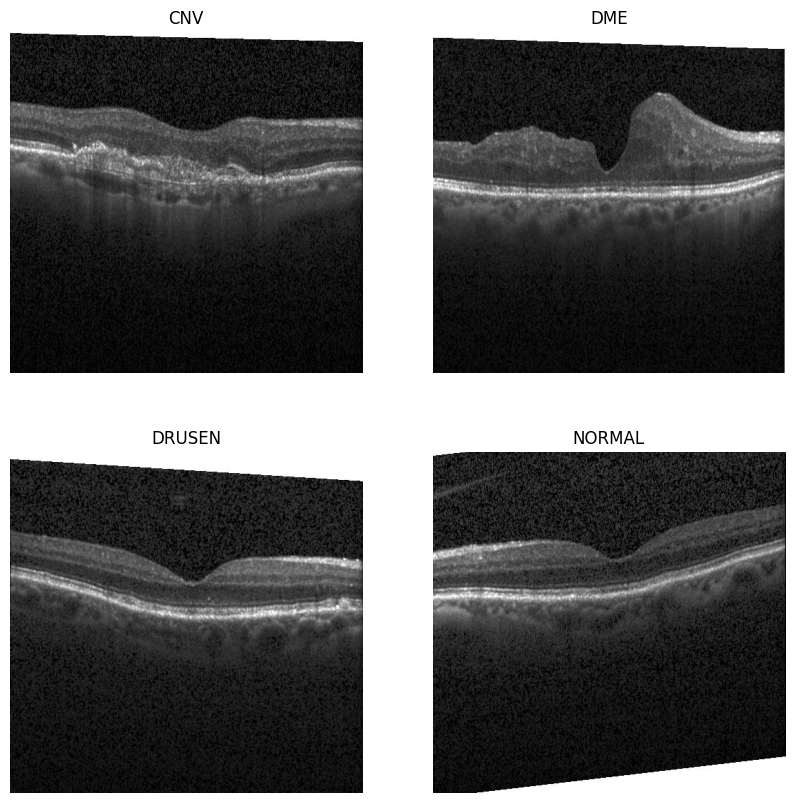

In [38]:
# visualizing a sample from each class

rows,cols,c=2,2,0

_, axs = plt.subplots(rows, cols, figsize=(10,10))
classes = os.listdir(train_dir)

for i in range(rows*cols):
  img = imread(os.path.join(train_dir, classes[i], os.listdir(os.path.join(train_dir, classes[i]))[0]))
  axs[c//cols][c%cols].imshow(img, cmap="gray")
  axs[c//cols][c%cols].set_axis_off()
  axs[c//cols][c%cols].set_title(classes[i])
  c+=1
plt.show()

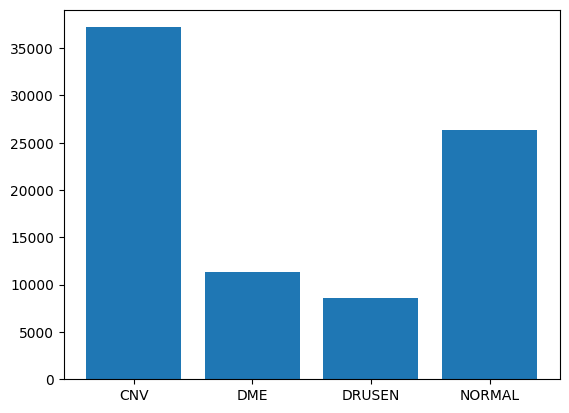

In [39]:
# frequency of the classes in the training set

frequency_classes = [len(os.listdir(os.path.join(train_dir, class_))) for class_ in classes]
plt.bar(classes, frequency_classes)
plt.show()

## Model Training and Evaluation

We use the ImageDataGenerator class to load the datasets from the folders, apply some transformations on them and create batches on the fly.

In [40]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator( rescale=1/255.0,
                              horizontal_flip=True)
datagen = tf.keras.preprocessing.image.ImageDataGenerator( rescale=1/255.0)

In [41]:
train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                              target_size=(WIDTH, HEIGHT),
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical",
                                              shuffle=True,
                                              seed=0)

validation_generator = datagen.flow_from_directory(directory=val_dir,
                                              target_size=(WIDTH, HEIGHT),
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical",
                                              shuffle=True,
                                              seed=0)
test_generator = datagen.flow_from_directory(directory=test_dir,
                                              target_size=(WIDTH, HEIGHT),
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical",
                                              seed=0)

Found 83484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


### Model Architecture

To create our model, we use the Sequential API from TensorFlow. The model has the following architecture:

- The first layer is a convolution layer that has 32 filters of size 3x3, relu activation and accepts input of shape (128, 128, 3).
- The second layer is again a convolution layer having 64 filters of size 3x3, relu activation and max-pooling with filter size of 2x2.
- The third and the final convolution layer has 64 filters of size 3x3, relu activation and max-pooling with filter size of 2x2. Finally, there is a flatten layer to flatten the output.
- The fourth layer is a dense layer with 128 units and relu activation.
- The final layer of the model is again a dense layer with 4 units and linear activation to get the unnormalized outputs.

In [43]:
tf.random.set_seed(1)

model = tf.keras.Sequential([
    # layer 1: convolution layer
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(WIDTH, HEIGHT, 3)),
    #layer 2: convolution layer with max-pooling
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    #layer 3: convolution layer with max-pooling
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Flatten(),
    #layer 4: dense layer
    tf.keras.layers.Dense(units=128, activation="relu"),
    # layer 5: dense layer
    tf.keras.layers.Dense(units=4, activation='linear')
])

In [44]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [46]:
# training the model

history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs=EPOCHS)

Epoch 1/12
2609/2609 [==============================] - 490s 188ms/step - loss: 0.5939 - accuracy: 0.7817 - val_loss: 0.2153 - val_accuracy: 0.9287
Epoch 2/12
2609/2609 [==============================] - 253s 97ms/step - loss: 0.3118 - accuracy: 0.8921 - val_loss: 0.2782 - val_accuracy: 0.8936
Epoch 3/12
2609/2609 [==============================] - 265s 101ms/step - loss: 0.2353 - accuracy: 0.9187 - val_loss: 0.0950 - val_accuracy: 0.9680
Epoch 4/12
2609/2609 [==============================] - 252s 96ms/step - loss: 0.1878 - accuracy: 0.9350 - val_loss: 0.0667 - val_accuracy: 0.9783
Epoch 5/12
2609/2609 [==============================] - 271s 104ms/step - loss: 0.1514 - accuracy: 0.9486 - val_loss: 0.0634 - val_accuracy: 0.9752
Epoch 6/12
2609/2609 [==============================] - 292s 112ms/step - loss: 0.1255 - accuracy: 0.9576 - val_loss: 0.1006 - val_accuracy: 0.9649
Epoch 7/12
2609/2609 [==============================] - 254s 97ms/step - loss: 0.1067 - accuracy: 0.9647 - val_los

After training for 12 epochs, we get training and validation accuracy of 98.37% and 98.66%. The training and validation accuracies show that the model is doing quite well and it is neither underfitting nor overfitting. Let's visualize the same using graphs and then we will check the performance of the model on the test set.

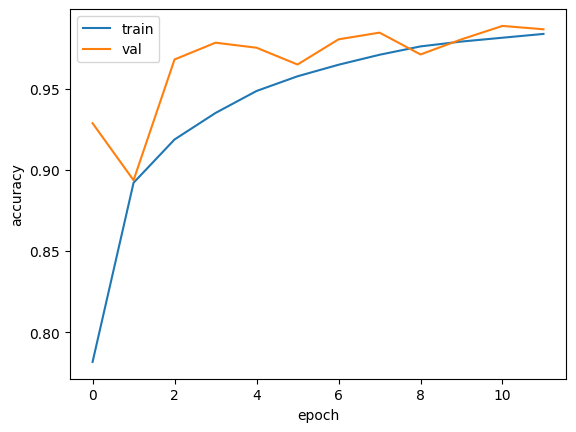

In [47]:
# accuracy plot

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

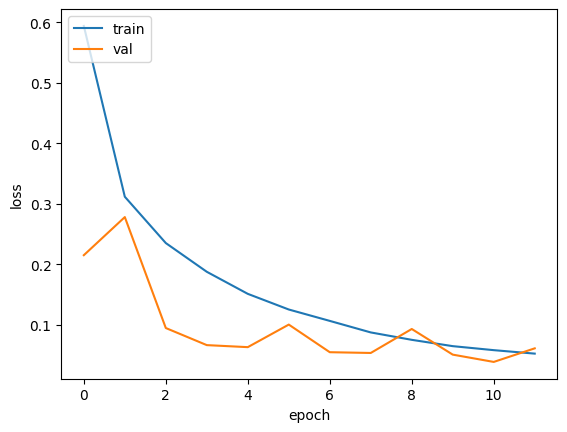

In [48]:
# loss plot

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Both the graphs show that the model is doing a great job at predicting the labels of training and validation sets.

Let's now evaluate the test set.

In [49]:
model.evaluate(test_generator)

1/1 [==============================] - 0s 347ms/step - loss: 0.1119 - accuracy: 0.9375


[0.11186173558235168, 0.9375]

The model is able to predict 30 out of 32 test samples correctly.

Let's visualize some data with their predictions.

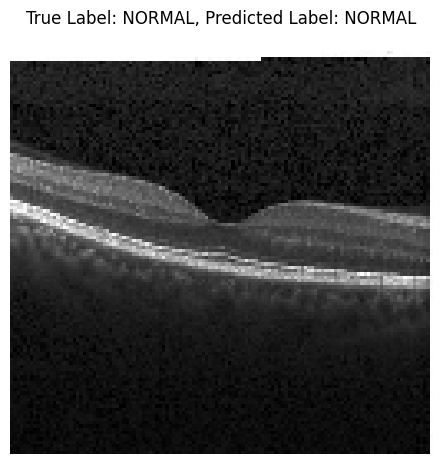

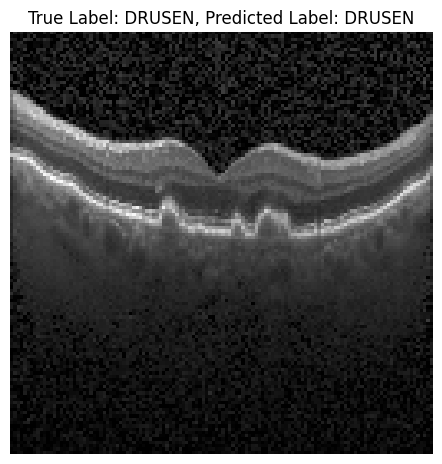

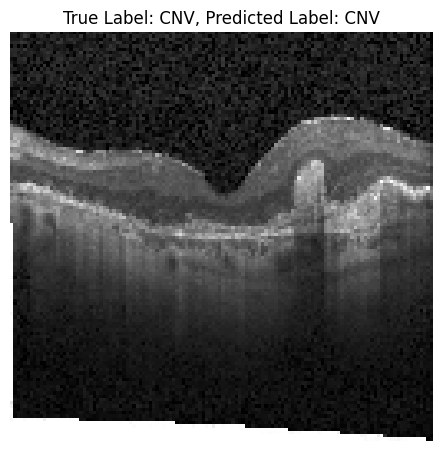

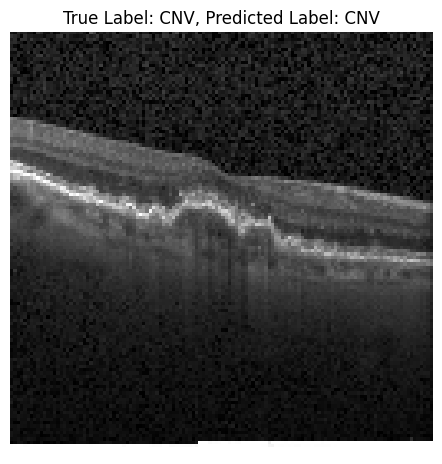

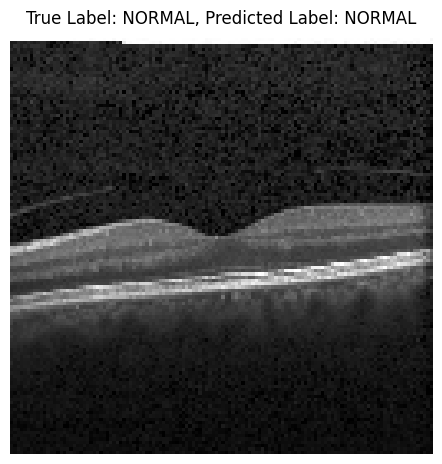

In [75]:
def predict(model, image, idx_class):
    return idx_class[model.predict(tf.expand_dims(image, axis=0)).argmax()]

def imshow(model, image, label, idx_class):
  io.imshow(image)
  plt.title("True Label: {}, Predicted Label: {}".format(idx_class[label.argmax()], predict(model, image, idx_class)))
  plt.axis("off")
  io.show()

x,y = test_generator.next()
class_idx = test_generator.class_indices
idx_class = {class_idx[key]: key for key in class_idx.keys()}

for i in range(0,5):
    image = x[i]
    label = y[i]
    imshow(model, image, label, idx_class)

Ta-da! All the images are classified correctly.